In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv
import json

# ------------------ Load and Prepare Data ------------------ #
data = pd.read_csv(r'J:/CancerInst/ImmunoTherapy/Lab_Current/Guillaume Mestrallet/Experiments/MLmetastasis/msk_met_2021/dataML.csv')
X = data.drop(columns=["TIME_TO_MET_OR_NOT_MET_AFTER_SEQUENCING", "MET_STATUS"])  # features
y = Surv.from_dataframe("MET_STATUS", "TIME_TO_MET_OR_NOT_MET_AFTER_SEQUENCING", data)  # Surv object

# ------------------ Define Model and Param Grid ------------------ #
rf_survival = RandomSurvivalForest(random_state=42)

param_grid = {
    "n_estimators": [10, 50, 100, 500],
    "max_depth": [None, 5, 10, 15, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 5, 10],
    "max_features": ["sqrt", "log2", 0.3, 0.5, None],
    "bootstrap": [True],  # Usually RSF uses bootstrapping
}

# ------------------ Step 1: Nested CV for Unbiased Performance ------------------ #
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
c_indices = []

for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
    print(f"\n--- Outer Fold {fold_idx + 1} ---")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Train on outer train set with default params
    base_model = RandomSurvivalForest(random_state=42)
    base_model.fit(X_train, y_train)

    # Evaluate on outer test fold
    y_pred_test = base_model.predict(X_test)
    c_index_test = concordance_index_censored(
        y_test["MET_STATUS"], y_test["TIME_TO_MET_OR_NOT_MET_AFTER_SEQUENCING"], y_pred_test
    )[0]

    print(f"Test C-Index: {c_index_test:.4f}")
    c_indices.append(c_index_test)

print(f"\n✅ Mean Nested CV Test C-Index: {np.mean(c_indices):.4f}")

# ------------------ Step 2: Hyperparameter Tuning on Full Dataset ------------------ #
print("\n🔍 Performing grid search on the full dataset for hyperparameter tuning...")

inner_cv = KFold(n_splits=5, shuffle=True, random_state=1)

grid_search = GridSearchCV(
    rf_survival,
    param_grid=param_grid,
    cv=inner_cv,
    n_jobs=-1,
    scoring=None,  # sksurv uses model.score, which is concordance
    refit=True
)

grid_search.fit(X, y)
best_params = grid_search.best_params_
print("\n🏆 Best Hyperparameters on Full Data:")
print(best_params)

# ------------------ Step 3: Final Model Training ------------------ #
final_model = RandomSurvivalForest(**best_params, random_state=42)
final_model.fit(X, y)

# ------------------ Save Results ------------------ #
results = {
    "fold_c_indices_nested_cv": c_indices,
    "mean_nested_cv_c_index": np.mean(c_indices),
    "selected_params_full_data": best_params,
}

with open("nestedcv_then_final_gridsearch_results.json", "w") as f:
    json.dump(results, f, indent=4)

# ------------------ Optional: Predict on External Cohort ------------------ #
# external_data = pd.read_csv("external_cohort.csv")
# X_ext = external_data.drop(columns=["OS_MONTHS", "OS_STATUS"])
# y_ext = Surv.from_dataframe("OS_STATUS", "OS_MONTHS", external_data)
# y_pred_ext = final_model.predict(X_ext)
# c_index_ext = concordance_index_censored(
#     y_ext["OS_STATUS"], y_ext["OS_MONTHS"], y_pred_ext
# )[0]
# print(f"\nExternal Cohort C-Index: {c_index_ext:.4f}")



--- Outer Fold 1 ---
Test C-Index: 0.7307

--- Outer Fold 2 ---
Test C-Index: 0.7272

--- Outer Fold 3 ---
Test C-Index: 0.7305

--- Outer Fold 4 ---
Test C-Index: 0.7019

--- Outer Fold 5 ---
Test C-Index: 0.7086

✅ Mean Nested CV Test C-Index: 0.7198

🔍 Performing grid search on the full dataset for hyperparameter tuning...

🏆 Best Hyperparameters on Full Data:
{'bootstrap': True, 'max_depth': 15, 'max_features': 0.3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 500}


In [2]:
best_model=final_model
best_model

RandomSurvivalForest(max_depth=15, max_features=0.3, min_samples_split=10,
                     n_estimators=500, random_state=42)

In [3]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

PermutationExplainer explainer: 4287it [234:01:03, 196.56s/it]                              
C:\Users\mestrg01\AppData\Local\Temp\ipykernel_12432\2667166550.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values2, X)


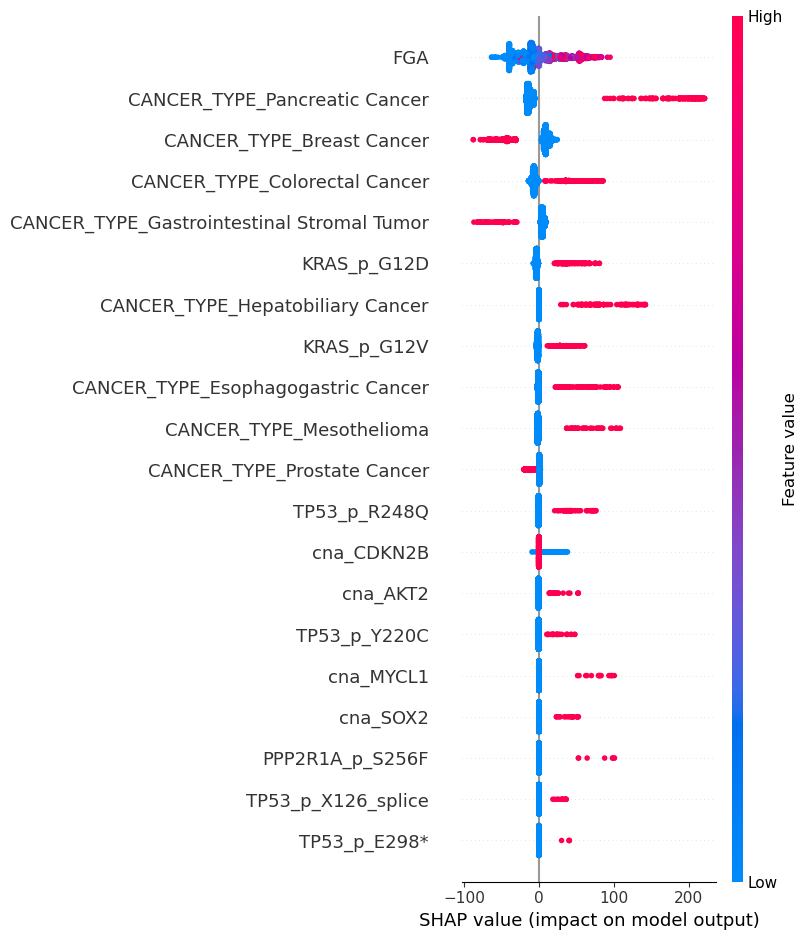

In [4]:
explainer2 = shap.Explainer(best_model.predict, X)  # Approximate SHAP for predictions
shap_values2 = explainer2(X, max_evals=6500)
shap.summary_plot(shap_values2, X)

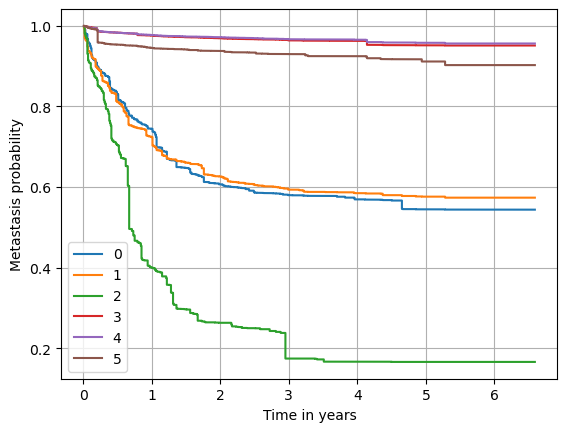

In [16]:
X_test_sorted = X_test.sort_values(by=['CANCER_TYPE_Gastrointestinal Stromal Tumor','CANCER_TYPE_Breast Cancer','CANCER_TYPE_Prostate Cancer','cna_CDKN2B'])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

X_test_sel

pd.Series(best_model.predict(X_test_sel))

surv = best_model.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(best_model.unique_times_, s, where="post", label=str(i))
plt.ylabel("Metastasis probability")
plt.xlabel("Time in years")
plt.legend()
plt.grid(True)

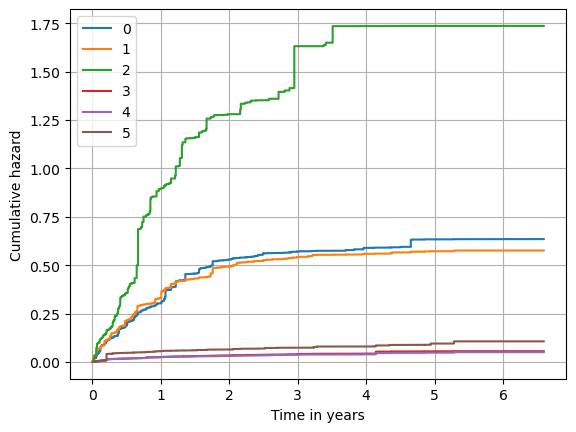

In [17]:
X_test_sorted = X_test.sort_values(by=['CANCER_TYPE_Gastrointestinal Stromal Tumor','CANCER_TYPE_Breast Cancer','CANCER_TYPE_Prostate Cancer','cna_CDKN2B'])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

X_test_sel

pd.Series(best_model.predict(X_test_sel))

surv = best_model.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(best_model.unique_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in years")
plt.legend()
plt.grid(True)

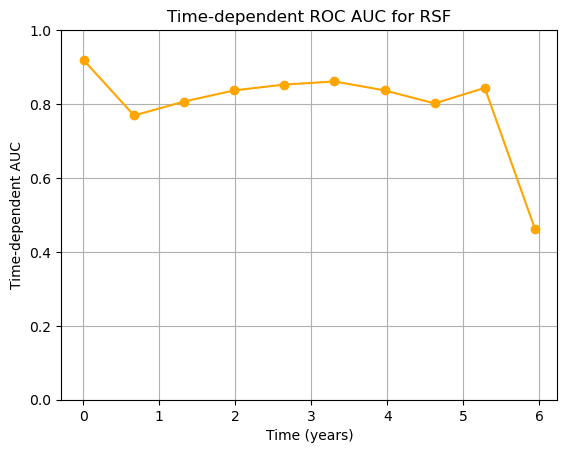

In [7]:
from sksurv.metrics import cumulative_dynamic_auc
import numpy as np

min_time = y_test["TIME_TO_MET_OR_NOT_MET_AFTER_SEQUENCING"].min()
max_time = y_test["TIME_TO_MET_OR_NOT_MET_AFTER_SEQUENCING"].max()

# Slightly shrink max time to stay strictly within interval
safe_max_time = max_time * 0.9999

# Generate safe time points
eval_times = np.linspace(min_time, safe_max_time, 10)

# Predict survival functions
pred_surv = best_model.predict_survival_function(X_test)

# Evaluate survival probabilities at the eval_times
pred_surv_matrix = np.asarray([[fn(t) for t in eval_times] for fn in pred_surv])
risk_scores = 1 - pred_surv_matrix

# Compute cumulative/dynamic AUC
cph_auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_scores, eval_times)

#plot
plt.plot(eval_times, cph_auc, marker='o', color='orange', label="data test")
plt.xlabel("Time (years)")
plt.ylabel("Time-dependent AUC")
plt.title("Time-dependent ROC AUC for RSF")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

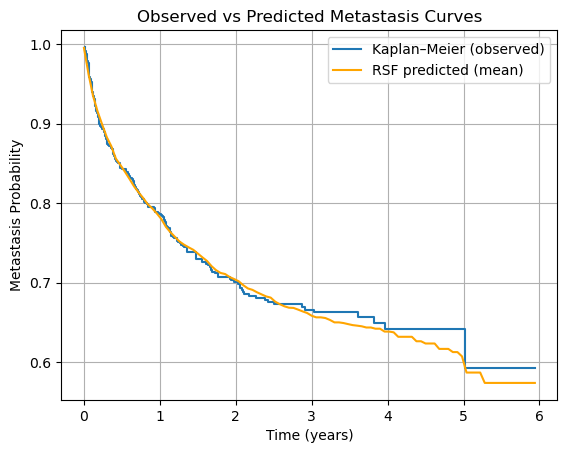

In [8]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

# Get event indicator and durations from test set
event = y_test["MET_STATUS"]
time = y_test["TIME_TO_MET_OR_NOT_MET_AFTER_SEQUENCING"]

# Compute KM estimate
km_time, km_survival = kaplan_meier_estimator(event, time)

# Predict survival functions for all test samples
pred_surv = best_model.predict_survival_function(X_test)

# Interpolate all survival functions to a common time grid
# Choose a common grid based on the KM time or a linspace
common_time_grid = np.linspace(0, time.max(), 100)

# Interpolate predicted survival values at these times
interp_surv = np.asarray([[fn(t) for t in common_time_grid] for fn in pred_surv])

# Compute mean predicted survival across all test samples
mean_pred_surv = interp_surv.mean(axis=0)

#plot
plt.step(km_time, km_survival, where="post", label="Kaplan–Meier (observed)")
plt.plot(common_time_grid, mean_pred_surv, label="RSF predicted (mean)", color="orange")
plt.xlabel("Time (years)")
plt.ylabel("Metastasis Probability")
plt.title("Observed vs Predicted Metastasis Curves")
plt.grid(True)
plt.legend()
plt.show()